In [84]:
## Importing modules ##

# Import PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader , Dataset

# progress bar
from tqdm.auto import tqdm

# for file system
import os

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# data modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc

# type
from typing import List , Dict 

In [85]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [86]:
import pandas as pd

# Read daily data
df_1d = pd.read_csv("btc_1d_data_2018_to_2025.csv")
print(df_1d.head())

# Read hourly data
df_1h = pd.read_csv("btc_1h_data_2018_to_2025.csv")
print(df_1h.head())

# Read 4-hour data
df_4h = pd.read_csv("btc_4h_data_2018_to_2025.csv")
print(df_4h.head())

# Read 15-minute data
df_15m = pd.read_csv("btc_15m_data_2018_to_2025.csv")
print(df_15m.head())


                        Open time      Open      High       Low     Close  \
0  2018-01-01 00:00:00.000000 UTC  13715.65  13818.55  12750.00  13380.00   
1  2018-01-02 00:00:00.000000 UTC  13382.16  15473.49  12890.02  14675.11   
2  2018-01-03 00:00:00.000000 UTC  14690.00  15307.56  14150.00  14919.51   
3  2018-01-04 00:00:00.000000 UTC  14919.51  15280.00  13918.04  15059.54   
4  2018-01-05 00:00:00.000000 UTC  15059.56  17176.24  14600.00  16960.39   

         Volume                      Close time  Quote asset volume  \
0   8609.915844  2018-01-01 23:59:59.999000 UTC        1.147997e+08   
1  20078.092111  2018-01-02 23:59:59.999000 UTC        2.797171e+08   
2  15905.667639  2018-01-03 23:59:59.999000 UTC        2.361169e+08   
3  21329.649574  2018-01-04 23:59:59.999000 UTC        3.127816e+08   
4  23251.491125  2018-01-05 23:59:59.999000 UTC        3.693220e+08   

   Number of trades  Taker buy base asset volume  \
0            105595                  3961.938946   
1     

In [88]:
files = [
    "btc_1d_data_2018_to_2025.csv",
    "btc_1h_data_2018_to_2025.csv",
    "btc_4h_data_2018_to_2025.csv",
    "btc_15m_data_2018_to_2025.csv"
]

data = {}

for file in files:
    name = file.split("_data")[0]  # 'btc_1d', 'btc_1h', etc.
    df_temp = pd.read_csv(file)
    # drop unnecessary columns
    df_temp = df_temp.drop(columns=['Open', 'High', 'Low', 'Adj Close'], errors='ignore')
    data[name] = df_temp
    print(f"{name} loaded, shape: {df_temp.shape}")


btc_1d loaded, shape: (2955, 9)
btc_1h loaded, shape: (70775, 9)
btc_4h loaded, shape: (17709, 9)
btc_15m loaded, shape: (283053, 9)


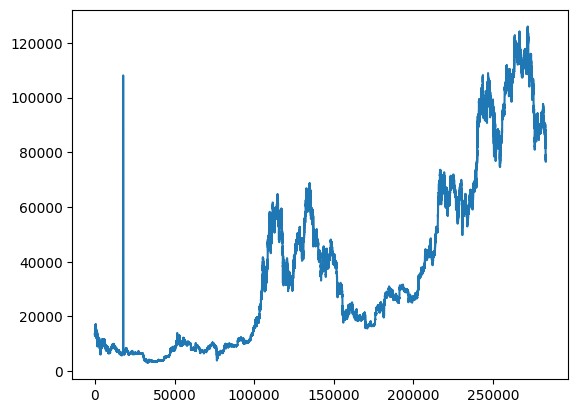

In [89]:
plt.plot(df_temp.index,df_temp['Close'])

In [90]:
# Keep only Close column (numeric)
df_numeric = df_temp[['Close']]
df_numeric.head()


,Close
0,13556.15
1,13521.12
2,13470.41
3,13529.01
4,13445.63


In [91]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform only the Close column
X_scaled = scaler.fit_transform(df_temp[['Close']])

# Check the first 5 scaled values
print(X_scaled[:5])


[[-0.8308575 ]
 [-0.83142782]
 [-0.83225341]
 [-0.83129936]
 [-0.83265685]]


In [92]:
# Keep ONLY Close column
df_temp = df_temp[['Close']]


# Scale Close
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(df_temp[['Close']])

# keep scaler for inverse transform later
scaler_clone = scaler

# back to DataFrame
df_scaled = pd.DataFrame(
    X_scaled,
    columns=['Close'],
    index=df_temp.index
)


# Now prepare shifted dataframe for LSTM
shifted_df = prepare_dataframe_for_lstm(df_scaled, n_shift)
shifted_df


,Close,Close(t-30),Close(t-29),Close(t-28),Close(t-27),Close(t-26),Close(t-25),Close(t-24),Close(t-23),Close(t-22),...,Close(t-10),Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
30,-0.829412,-0.830857,-0.831428,-0.832253,-0.831299,-0.832657,-0.830795,-0.832748,-0.836606,-0.833611,...,-0.829702,-0.829842,-0.830469,-0.830811,-0.831245,-0.828715,-0.828150,-0.827206,-0.827294,-0.828548
31,-0.830626,-0.831428,-0.832253,-0.831299,-0.832657,-0.830795,-0.832748,-0.836606,-0.833611,-0.836249,...,-0.829842,-0.830469,-0.830811,-0.831245,-0.828715,-0.828150,-0.827206,-0.827294,-0.828548,-0.829412
32,-0.829228,-0.832253,-0.831299,-0.832657,-0.830795,-0.832748,-0.836606,-0.833611,-0.836249,-0.834685,...,-0.830469,-0.830811,-0.831245,-0.828715,-0.828150,-0.827206,-0.827294,-0.828548,-0.829412,-0.830626
33,-0.829608,-0.831299,-0.832657,-0.830795,-0.832748,-0.836606,-0.833611,-0.836249,-0.834685,-0.834536,...,-0.830811,-0.831245,-0.828715,-0.828150,-0.827206,-0.827294,-0.828548,-0.829412,-0.830626,-0.829228
34,-0.832835,-0.832657,-0.830795,-0.832748,-0.836606,-0.833611,-0.836249,-0.834685,-0.834536,-0.832667,...,-0.831245,-0.828715,-0.828150,-0.827206,-0.827294,-0.828548,-0.829412,-0.830626,-0.829228,-0.829608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283048,0.209485,0.212131,0.201798,0.204823,0.211720,0.211371,0.210756,0.206004,0.210114,0.212498,...,0.205203,0.196991,0.208842,0.203737,0.197866,0.201927,0.199477,0.194342,0.210060,0.205253
283049,0.206118,0.201798,0.204823,0.211720,0.211371,0.210756,0.206004,0.210114,0.212498,0.211118,...,0.196991,0.208842,0.203737,0.197866,0.201927,0.199477,0.194342,0.210060,0.205253,0.209485
283050,0.196193,0.204823,0.211720,0.211371,0.210756,0.206004,0.210114,0.212498,0.211118,0.209804,...,0.208842,0.203737,0.197866,0.201927,0.199477,0.194342,0.210060,0.205253,0.209485,0.206118
283051,0.198817,0.211720,0.211371,0.210756,0.206004,0.210114,0.212498,0.211118,0.209804,0.214193,...,0.203737,0.197866,0.201927,0.199477,0.194342,0.210060,0.205253,0.209485,0.206118,0.196193


In [93]:
def prepare_dataframe_for_lstm(df_temp, n_steps):
    df = df_temp.copy()
    
    for i in range(n_steps, 0, -1):
        df_temp[f'Close(t-{i})'] = df_temp['Close'].shift(i)
    
    df_temp.dropna(inplace=True)
    return df_temp

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

n_shift = 30
shifted_df = prepare_dataframe_for_lstm(df_scaled, n_shift)
shifted_df.head()


,Close,Close(t-30),Close(t-29),Close(t-28),Close(t-27),Close(t-26),Close(t-25),Close(t-24),Close(t-23),Close(t-22),...,Close(t-10),Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
60,-0.837213,-0.829412,-0.830626,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,...,-0.836656,-0.837105,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470
61,-0.834820,-0.830626,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,...,-0.837105,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213
62,-0.835923,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,...,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820
63,-0.835891,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,-0.830973,...,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820,-0.835923
64,-0.836851,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,-0.830973,-0.830363,...,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820,-0.835923,-0.835891


In [94]:

df_scaled.head()


,Close,Close(t-30),Close(t-29),Close(t-28),Close(t-27),Close(t-26),Close(t-25),Close(t-24),Close(t-23),Close(t-22),...,Close(t-10),Close(t-9),Close(t-8),Close(t-7),Close(t-6),Close(t-5),Close(t-4),Close(t-3),Close(t-2),Close(t-1)
60,-0.837213,-0.829412,-0.830626,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,...,-0.836656,-0.837105,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470
61,-0.834820,-0.830626,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,...,-0.837105,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213
62,-0.835923,-0.829228,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,...,-0.839244,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820
63,-0.835891,-0.829608,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,-0.830973,...,-0.840284,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820,-0.835923
64,-0.836851,-0.832835,-0.831772,-0.830309,-0.830961,-0.830144,-0.829867,-0.830958,-0.830973,-0.830363,...,-0.838610,-0.839635,-0.842027,-0.841101,-0.839912,-0.836470,-0.837213,-0.834820,-0.835923,-0.835891


In [95]:
import numpy as np

y = shifted_df['Close'].to_numpy()
X = shifted_df.iloc[:, 1:].to_numpy()  # all lagged Close columns
X = X.reshape(X.shape[0], X.shape[1], 1)  # add 3rd dimension for LSTM

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (282993, 30, 1)
y shape: (282993,)


In [96]:
#split data into training , testing ,and validation dataset
split_index_1 , split_index_2 = int(X.shape[0] * 0.8) , int(X.shape[0] * 0.9)

X_train = X[:split_index_1]
X_test = X[split_index_1:split_index_2]
X_val = X[split_index_2:]

y_train = y[:split_index_1]
y_test = y[split_index_1:split_index_2]
y_val = y[split_index_2:]

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((226394, 30, 1),
 (28299, 30, 1),
 (28300, 30, 1),
 (226394,),
 (28299,),
 (28300,))

In [97]:
# transform from numpy array to tensor

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

(torch.Size([226394, 30, 1]),
 torch.Size([28299, 30, 1]),
 torch.Size([28300, 30, 1]),
 torch.Size([226394]),
 torch.Size([28299]),
 torch.Size([28300]))

In [98]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

len(train_dataset), len(test_dataset)


(226394, 28299)

In [99]:
# load data into DataLoader
batch_size = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=False)

In [100]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out.squeeze()

In [101]:
# create model object
try:
  import torchinfo
except:
  %pip install torchinfo
  import torchinfo

from torchinfo import summary

model_0 = LSTM(input_size=1, hidden_size=64, num_stacked_layers=1).to(device)

#[batch_size,sequence_length,input_features]
summary(model_0, input_size=[1, n_shift, 1])

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     --                        --
├─LSTM: 1-1                              [1, 30, 64]               17,152
├─Linear: 1-2                            [1, 1]                    65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.51
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.07
Estimated Total Size (MB): 0.08

In [102]:
# train loop function
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               scheduler:torch.optim.lr_scheduler = None,
               grad_clip:float=None):

  model.train()

  train_loss = 0 

  for batch , (X,y) in enumerate(dataloader):

    X , y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()

  train_loss /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss)


  return train_loss 

In [103]:
# test loop function
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):

    model.eval()

    test_loss = 0

    with torch.inference_mode():
        for batch , (X,y) in enumerate(dataloader):
            X , y = X.to(device) , y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred,y)
            test_loss += loss.item()

        test_loss /= len(dataloader)

    return test_loss 


In [104]:
#Creating a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          grad_clip:float=None,      
          epochs: int = 10):

    results = {"train_loss": [],
        "test_loss": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                scheduler=scheduler,
                                grad_clip=grad_clip)
        test_loss  = test_step(model=model,
                               dataloader=test_dataloader,
                               loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "  
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f}"

        )


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results


In [105]:
# function to plot loss & accuracy curve

def plot_loss_curves(results: Dict[str, List[float]]):


    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']


    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(7, 7))

    # Plot loss
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.grid()
    plt.legend()

In [106]:
# Let's train
NUM_EPOCHS = 30
learning_rate = 0.001
weight_decay = 1e-5
grad_clip = 0.001

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model_0.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.3,patience=4,threshold=0.08)


from timeit import default_timer as timer
start_time = timer()


model_0_results = train(model=model_0,
                        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True),
                        test_dataloader  = DataLoader(test_dataset, batch_size=64, shuffle=False),
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  3%|▎         | 1/30 [00:41<20:14, 41.87s/it]

Epoch: 1 | train_loss: 0.0023 | test_loss: 0.0013


  7%|▋         | 2/30 [01:22<19:18, 41.37s/it]

Epoch: 2 | train_loss: 0.0000 | test_loss: 0.0011


 10%|█         | 3/30 [02:12<20:17, 45.08s/it]

Epoch: 3 | train_loss: 0.0000 | test_loss: 0.0007


 10%|█         | 3/30 [02:45<24:50, 55.22s/it]


KeyboardInterrupt: 

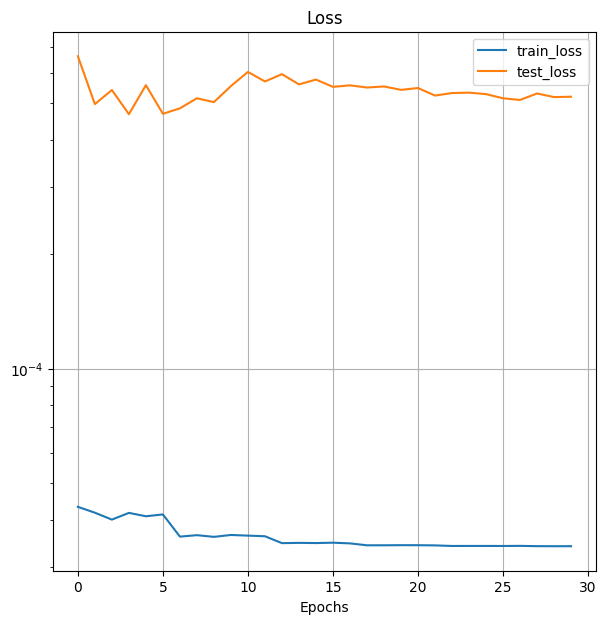

In [107]:
plot_loss_curves(model_0_results)

In [108]:
# function to test model on validation dataset
def test_on_val(model:nn.Module,X:torch.Tensor,y:torch.Tensor):
     
    model.eval()

    with torch.inference_mode():
        X , y = X.to(device) , y.to(device)
        y_pred = model(X)
        y , y_pred = y.to('cpu').numpy() , y_pred.to('cpu').numpy()
        y = scaler_clone.inverse_transform(np.expand_dims(y, axis=1)).squeeze()
        y_pred = scaler_clone.inverse_transform(np.expand_dims(y_pred, axis=1)).squeeze()
        error = (y_pred - y) / y
        
        fig, axs = plt.subplots(2,1, figsize=(10, 15)) 
    
        axs[0].plot(y, label='Actual Close')
        axs[0].plot(y_pred, label='Predicted Close')
        axs[0].set_title('Prediction')
        axs[0].set_xlabel('Day')
        axs[0].set_ylabel('Close')
        axs[0].legend()
        
        axs[1].hist(error * 100, bins=20, color='blue', alpha=0.7)
        axs[1].set_title('Distribution of Relative error')
        axs[1].set_xlabel('Error (%)')
        axs[1].set_ylabel('Frequency')
        axs[1].grid(True)
        plt.show()
        
        print(f"Relative error(%) min : {(error.min() * 100):.2f} %")
        print(f"Relative error(%) max : {(error.max() * 100):.2f} %")
        print(f"Relative error(%) mean : {(error.mean() * 100):.2f} %")
        print(f"Relative error(%) std : {(error.std() * 100):.2f} %")
        

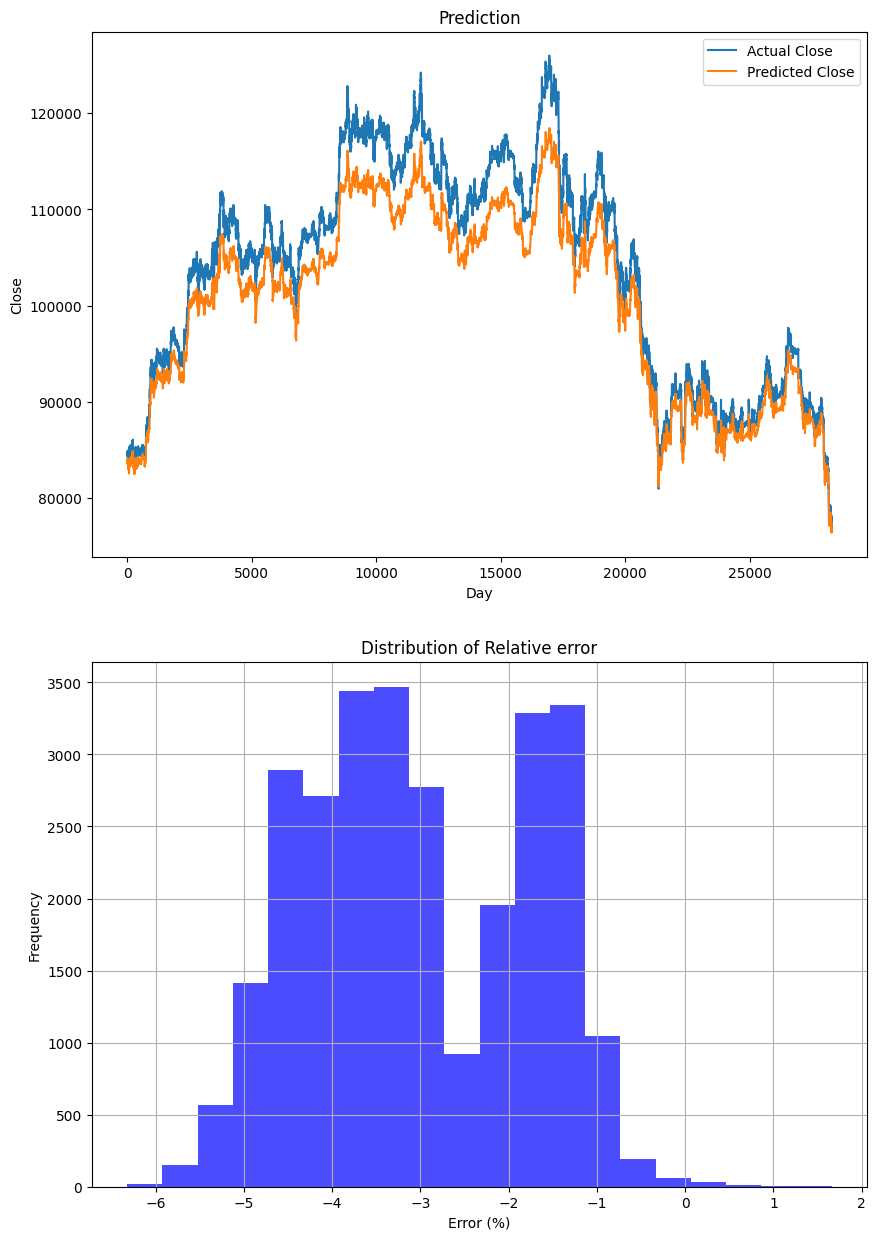

Relative error(%) min : -6.32 %
Relative error(%) max : 1.66 %
Relative error(%) mean : -3.02 %
Relative error(%) std : 1.26 %


In [109]:
test_on_val(model=model_0,
           X=X_val,
           y=y_val)